In [1]:
import os
from  urllib.request import urlopen
from urllib.parse import urlparse
import json
import nibabel as nib
import nilearn 
import pandas
from extract_from_masks import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
atlas_location = '/home/jflournoy/code/arbitrary_nii_extraction/atlas'
data_file = '/home/jflournoy/code/arbitrary_nii_extraction/test_file/Gaebler.nii.gz'
update_atlas = True
atlas_json_fname = 'atlas_info.json'
statistic_arg = 'two_sample_t'
outputdir = '/home/jflournoy/code/arbitrary_nii_extraction/output'
n = 23
prefix = 'effect_sizes'

In [3]:
def download_nii(url, dl_dir):
    parsed_url = urlparse(url)
    atlas_fname = os.path.split(parsed_url.path)[1]
    save_fname = os.path.join(dl_dir, atlas_fname)
    print('Downloading: ' + save_fname)
    response = urlopen(url)
    CHUNK = 16 * 1024
    with open(save_fname, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                break
            f.write(chunk)
        f.close()
    return(save_fname)

def update_atlases(which = None, atlas_dir = ''):
    url = "http://neurovault.org/api/atlases/"
    response = urlopen(url)
    data = response.read().decode("utf-8")
    atlases = json.loads(data)
    if (which == None):
        i = 0
        atlas_list = list()
        for result in atlases['results']:
            atlas_list.append(result['name'])
            print(i, ':', result['name'])
            i+=1
        raise ValueError('Please supply the index (as above) of the atlas you wish to update, or "all"')
    elif (which == 'all'):
        assert os.path.isdir(atlas_dir), 'Directory does not exist'
        for result in atlases['results']:
            local_fname = download_nii(url = result['file'], dl_dir = atlas_dir)
            
            result['local_file'] = local_fname
        json_fname = os.path.join(atlas_dir, atlas_json_fname)
        with open(json_fname, 'w') as f:
            json.dump(atlases, f)
            f.close()     

def get_atlas_fname(which = None, atlas_dir = ''):
    atlas_json_fullpath = os.path.join(atlas_dir, atlas_json_fname)
    assert os.path.isfile(atlas_json_fullpath), 'Atlas info doesn\'t exist. Run with --update_atlases?'
    with open(atlas_json_fullpath) as json_file:
        atlases = json.load(json_file)
        json_file.close()
    #Build list of atlases
    if (which == None):
        print('\n'.join([str(i) + ': ' + x['name'] for i, x in enumerate(atlases['results'])]))
        raise ValueError('Please supply the index (as above) of the atlas you wish to update, or "all"')
    atlas_fname = atlases['results'][which]['local_file']
    return(atlas_fname)

def apply_arbitrary_function(the_voxels_dict, theFunction):
    #the_voxels is a dict with a key that is a label for each mask and value that is an array of voxels
    #theFunction is a function that takes an array and returns a dictionary of summary statistics
    parcel_stats = dict()
    for k, the_voxels in the_voxels_dict.items():
        stats_dict = theFunction(the_voxels)
        parcel_stats[k] = stats_dict
    return(parcel_stats)

def save_stats_to_brains(atlas, raw_brain, stats, prefix, outdir):
    atlas_brain_data = atlas.get_data()
    raw_brain_data = raw_brain.get_data()
    stat_keys = stats[labels[0]]
    final_brains = dict()
    for stat in stat_keys:
        for label in stats_per_parcel:
            raw_brain_data[atlas_brain_data == label] = stats[label][stat]
        anewimage = nilearn.image.copy_img(nilearn.image.new_img_like(raw_brain, raw_brain_data))
        final_brains[stat] = anewimage
        final_brains[stat].to_filename(filename=os.path.join(outdir, prefix+'_'+stat+'.nii'))
    return(final_brains)

#These kinds of functions should always return a dictionary that
#names the statistic as the key, which is paired with the value
def eff_size_2grp_t_gen(sample_size):
    #Sample size should be sample size per group
    def eff_size_2grp_t(t_stats):
        import numpy as np
        #d = t * (sqrt(2/n)) via http://jakewestfall.org/blog/index.php/2016/03/25/five-different-cohens-d-statistics-for-within-subject-designs/
        d = t_stats * (2/sample_size)**(.5)
        return({'d_mean': np.mean(d), 'd_std': np.std(d)})
    return(eff_size_2grp_t)

In [4]:
atlas_fname = get_atlas_fname(which = 3, atlas_dir = atlas_location)
masks, labels = generate_masks(atlas_fname)
an_img_file = nib.load(data_file)
an_img_file_resamp = nilearn.image.resample_to_img(source_img=an_img_file, target_img=masks[0], interpolation='nearest')
voxels_from_masks = extract_from_masks(masks, an_img_file_resamp, masknames=labels)
if statistic_arg == 'two_sample_t':
    theFunction = eff_size_2grp_t_gen(n)
stats_per_parcel = apply_arbitrary_function(voxels_from_masks, theFunction)
atlas_brain = nib.load(atlas_fname)
final_brains = save_stats_to_brains(atlas_brain, an_img_file_resamp, stats_per_parcel, prefix, outputdir)

/home/jflournoy/miniconda3/envs/py3nii/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:430: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


In [5]:
from nilearn import plotting

/home/jflournoy/miniconda3/envs/py3nii/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


/home/jflournoy/miniconda3/envs/py3nii/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


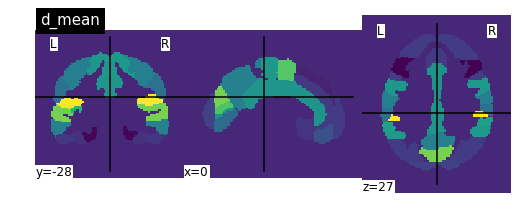

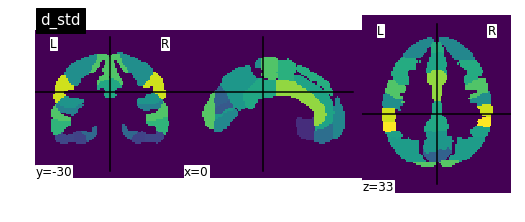

In [6]:
for k, v in final_brains.items():
    plotting.plot_img(v, title=k)

In [7]:
stats_table = pandas.DataFrame.from_dict(stats_per_parcel, orient = 'index')
stats_table.to_csv(os.path.join(outputdir, prefix+'_parcel_estimates.csv'))